# Loading packages and the RNN files

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.stats
import scipy
import random

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def cos_sim(a,b):
    cos_sim = np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

def get_cis(x):
    ci_h = np.zeros([x.shape[1],2])
    for idx in range(x.shape[1]):
        data = x[:,idx]
        ci_h[idx,:] = scipy.stats.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data),
                                             scale=scipy.stats.sem(data))
    return ci_h

In [3]:
# loading miniecoset labels

dataset_path = './miniecoset_64px.h5'

with h5py.File(dataset_path, "r") as f:
    category_labels = f['categories'][()]
    sample_image = f['train']['data'][0,:,:,:]
    
for i in range(len(category_labels)):
    category_labels[i] = category_labels[i].decode()

Sample image from Miniecoset


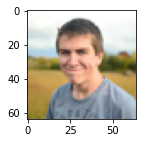

In [4]:
# sample image from miniecoset

plt.figure(figsize=(2, 2))
plt.imshow(sample_image);
print('Sample image from Miniecoset')

In [5]:
# loading the relevant net save file

lateral_connections = 1
topdown_connections = 0
lt_interact = 'additive'
timesteps = 10
lt_position = 'all'
net_num = 1

load_epoch = -2 # this loads the final model (-1 loads the random init)

net_name = f'b64_l_{lateral_connections}_t_{topdown_connections}_ltinteract_{lt_interact}\
_T_{timesteps}_ltposition_{lt_position}_num_{net_num}'

if load_epoch == -2:
    actvs_save_name = f'saved_actvs/{net_name}/{net_name}.npz'
else:
    actvs_save_name = f'saved_actvs/{net_name}/{net_name}_epoch_{load_epoch}.npz'

print('Net_file: ',actvs_save_name)

actvs_save_name_init = f'saved_actvs/{net_name}/{net_name}_epoch_{-1}.npz'

Net_file:  saved_actvs/b64_l_1_t_0_ltinteract_additive_T_10_ltposition_all_num_1/b64_l_1_t_0_ltinteract_additive_T_10_ltposition_all_num_1.npz


In [6]:
# loading the relevant net representations and parameters

data = np.load(actvs_save_name)
outputs_all = np.exp(data['outputs_all'])
outputs_all_labels = data['labels_all']
avgpool_all = data['representations_all']
rdout_w = data['readout_weight'].T
rdout_b = data['readout_bias']

data = np.load(actvs_save_name_init)
outputs_all_init = np.exp(data['outputs_all'])
avgpool_all_init = data['representations_all']
rdout_w_init = data['readout_weight'].T
rdout_b_init = data['readout_bias']

In [7]:
rdout_w.shape

(512, 100)

# Analysis

### Categorisation accuracy through time

t for max accuracy:  6 ; acc =  53.344 %



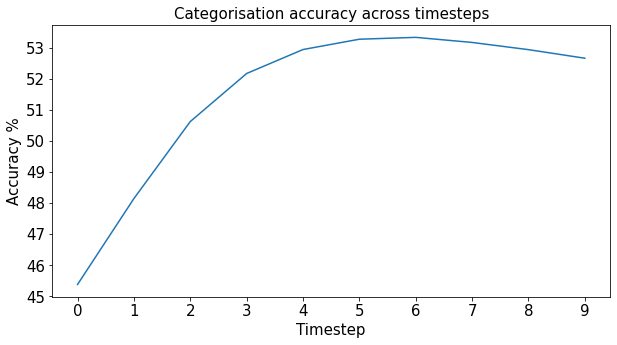

In [8]:
acc_t = np.zeros([timesteps,])
acc_t_init = np.zeros([timesteps,])
for t in range(timesteps):
    acc_t[t] = np.mean(np.argmax(outputs_all[t],axis=1)*1. == outputs_all_labels)
    acc_t_init[t] = np.mean(np.argmax(outputs_all_init[t],axis=1)*1. == outputs_all_labels)
    
plt.figure(figsize=(10,5))
plt.plot(range(timesteps),acc_t*100)
# plt.plot(range(timesteps),acc_t_init*100)
plt.yticks(fontsize=15);
plt.xticks(range(timesteps),fontsize=15);
plt.ylabel('Accuracy %',fontsize=15)
plt.xlabel('Timestep',fontsize=15)
plt.title('Categorisation accuracy across timesteps',fontsize=15);

print('t for max accuracy: ',np.argmax(acc_t),'; acc = ',np.max(acc_t)*100,'%\n')

### Dendrogram of readout vectors

In [9]:
# rdmh = (1-np.corrcoef(rdout_w.T))/2
rdmh = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        rdmh[i,j] = (1-cos_sim(rdout_w[:,i],rdout_w[:,j]))/2
rdmh = (rdmh+rdmh.T)/2
for i in range(100):
    rdmh[i,i] = 0
rdm_readout = squareform(rdmh)

Hierarchical clustering of readout vectors


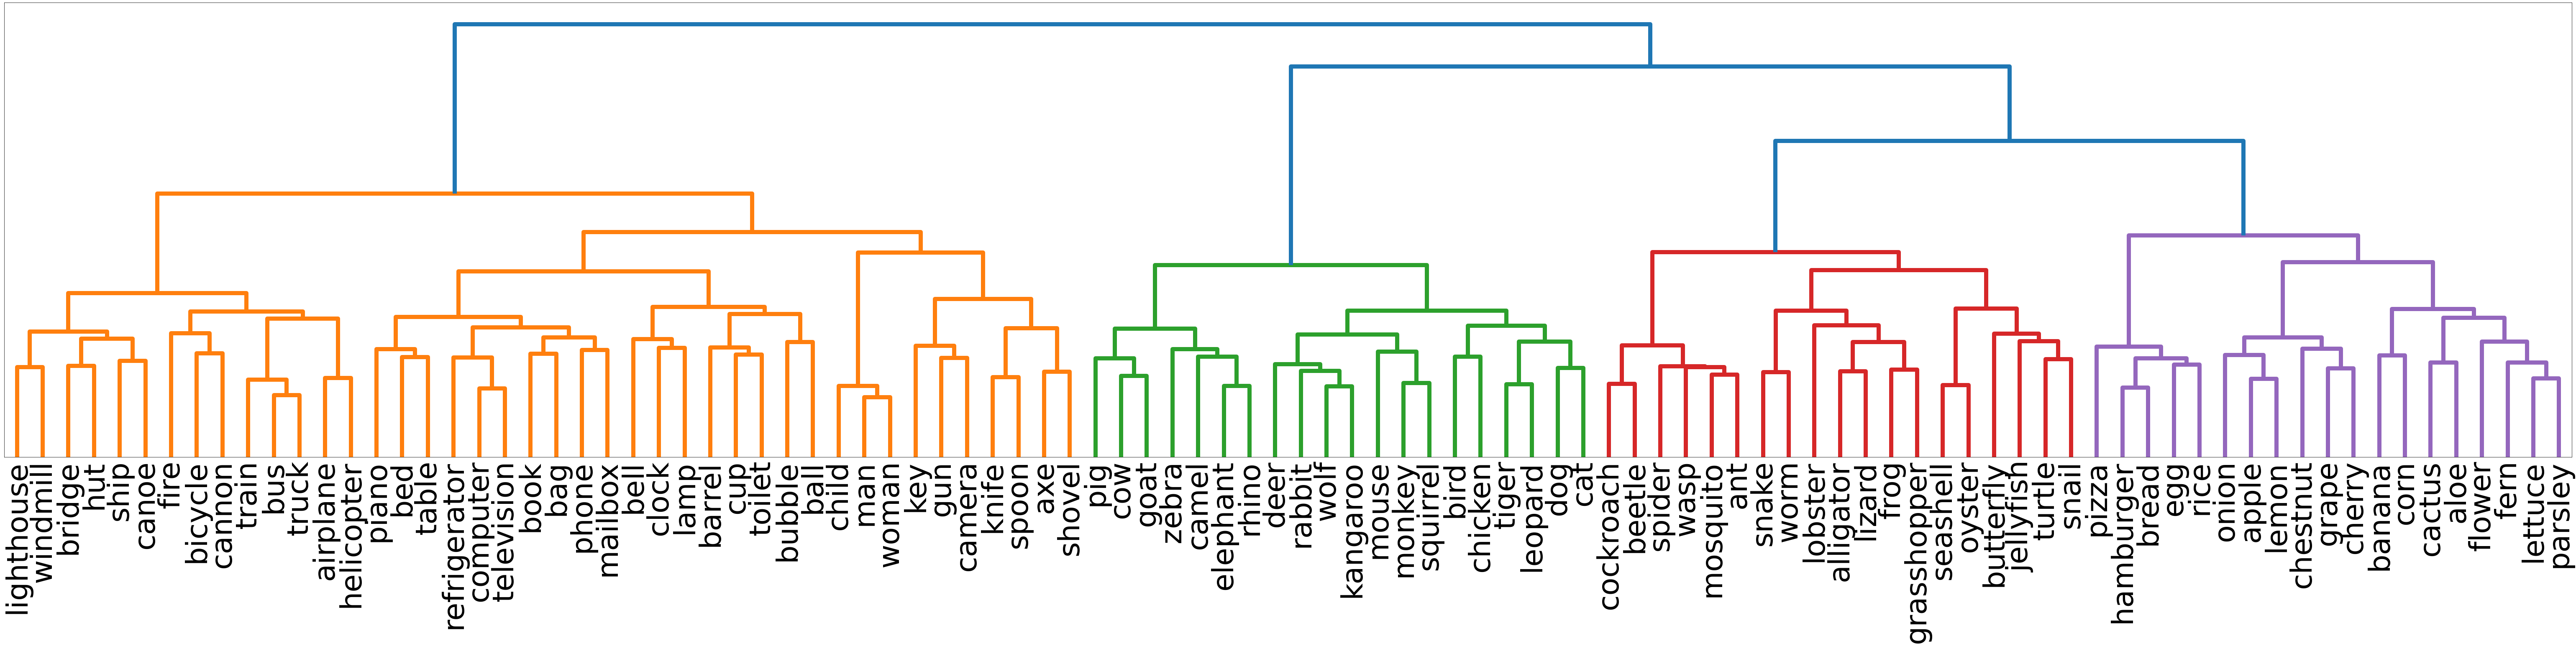

In [10]:
plt.figure(figsize=(110, 20))
linkage_data = linkage(rdm_readout, method='ward', metric='euclidean');
with plt.rc_context({'lines.linewidth': 10}):
    sort_dict_ft = dendrogram(linkage_data, labels=category_labels);
plt.tick_params(axis='x', which='major', labelsize=70)
plt.yticks([]);
print('Hierarchical clustering of readout vectors')

### Extracting the splits based on classification dynamics

In [11]:
stable_correct_ids = []
t_stable_correct = []

stable_incorrect_ids = []
t_stable_incorrect = []
label_stable_incorrect = []

unstable_correct_ids = []
t_unstable_correct = []
unstable_incorrect_ids = []

for idx in range(len(outputs_all_labels)):
    
    stability_flag = 0
    true_label = int(outputs_all_labels[idx])
    output_label_t = np.argmax(outputs_all[:,idx,:],1)
    for t in reversed(range(timesteps-1)):
        t_class_now = np.argmax(outputs_all[t,idx,:])
        t_class_next = np.argmax(outputs_all[t+1,idx,:])
        if t_class_now == t_class_next:
            stability_flag = 1
        else:
            if stability_flag == 1:
                t_first_stable = t+1
                stable_class = t_class_next
                if np.min(np.where(np.argmax(outputs_all[:,idx,:],1) == stable_class)[0]) == t_first_stable: #stable
                    if stable_class == true_label: #stable-correct
                        stable_correct_ids.append(idx)
                        t_stable_correct.append(t_first_stable)
                    else: #stable-incorrect
                        stable_incorrect_ids.append(idx)
                        t_stable_incorrect.append(t_first_stable)
                        label_stable_incorrect.append(stable_class)
                else: #unstable
                    if true_label in np.argmax(outputs_all[:,idx,:],1): #unstable_correct
                        unstable_correct_ids.append(idx)
                        t_unstable_correct.append(np.min(np.where(np.argmax(outputs_all[:,idx,:],1) == true_label)[0]))
                    else: #unstable_incorrect
                        unstable_incorrect_ids.append(idx)
                stability_flag = 0
                break
            else: #unstable - can only be hit at timestep-1
                if true_label in np.argmax(outputs_all[:,idx,:],1): #unstable_correct
                    unstable_correct_ids.append(idx)
                    t_unstable_correct.append(np.min(np.where(np.argmax(outputs_all[:,idx,:],1) == true_label)[0]))
                else: #unstable_incorrect
                    unstable_incorrect_ids.append(idx)
                stability_flag = 0
                break
    if stability_flag == 1: #stable - can only be hit if stable throughout
        stable_class = t_class_next
        if stable_class == true_label: #stable-correct
            stable_correct_ids.append(idx)
            t_stable_correct.append(0)
        else: #stable-incorrect
            stable_incorrect_ids.append(idx)
            t_stable_incorrect.append(0)
            label_stable_incorrect.append(stable_class)

print(f'Total samples #: {len(outputs_all_labels)}, 100.0%')
print(f'Stable_correct #: {len(stable_correct_ids)}, {len(stable_correct_ids)/len(outputs_all_labels)*100.:.1f}%')
print(f'Stable_incorrect #: {len(stable_incorrect_ids)}, {len(stable_incorrect_ids)/len(outputs_all_labels)*100.:.1f}%')
print(f'Unstable_correct #: {len(unstable_correct_ids)}, {len(unstable_correct_ids)/len(outputs_all_labels)*100.:.1f}%')
print(f'Unstable_incorrect #: {len(unstable_incorrect_ids)}, {len(unstable_incorrect_ids)/len(outputs_all_labels)*100.:.1f}%')

stable_correct_ids = np.array(stable_correct_ids)
t_stable_correct = np.array(t_stable_correct)
stable_incorrect_ids = np.array(stable_incorrect_ids)
t_stable_incorrect = np.array(t_stable_incorrect)
label_stable_incorrect = np.array(label_stable_incorrect)
unstable_correct_ids = np.array(unstable_correct_ids)
t_unstable_correct = np.array(t_unstable_correct)
unstable_incorrect_ids = np.array(unstable_incorrect_ids)
        

Total samples #: 25000, 100.0%
Stable_correct #: 12418, 49.7%
Stable_incorrect #: 9850, 39.4%
Unstable_correct #: 1295, 5.2%
Unstable_incorrect #: 1437, 5.7%


#samples per t (trained):  [9609, 917, 627, 411, 285, 219, 159, 103, 88, 0]


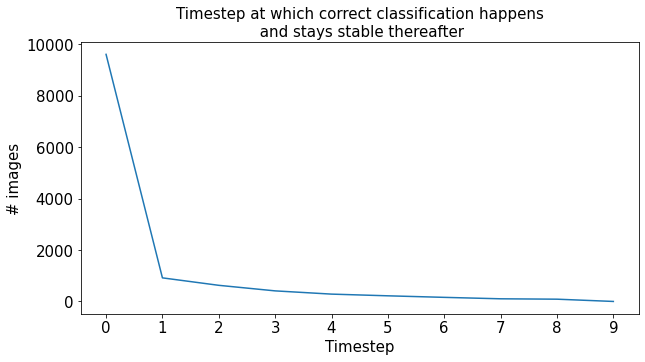

In [12]:
t_arr_trained = [np.sum(t_stable_correct==t) for t in range(timesteps)]
print('#samples per t (trained): ',t_arr_trained)

plt.figure(figsize=(10,5))
plt.plot(range(timesteps),t_arr_trained)
plt.yticks(fontsize=15);
plt.xticks(range(np.shape(outputs_all)[0]),fontsize=15);
plt.ylabel('# images',fontsize=15)
plt.xlabel('Timestep',fontsize=15)
plt.title('Timestep at which correct classification happens\n and stays stable thereafter',fontsize=15);

### Change in representation as a function of time to (correct) stable classification

It seems that, on average, representations change to the same extent. The change decreases in time too. Why might that be? In any case, stable classifications are not accompanied by stagnant representations.


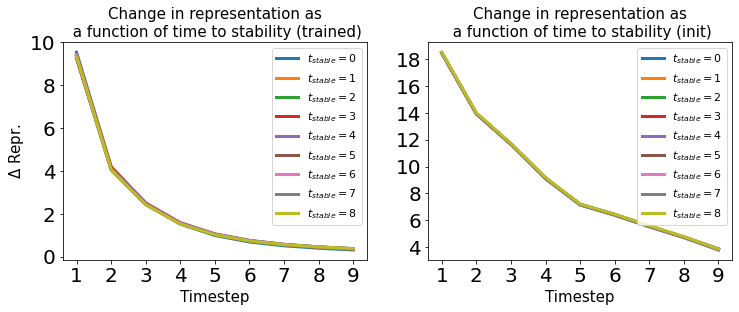

In [13]:
norm_change_in_repr = np.zeros([len(stable_correct_ids),timesteps-1])
norm_change_in_repr_init = np.zeros([len(stable_correct_ids),timesteps-1])

for n,idx in enumerate(stable_correct_ids):
    for t in range(timesteps-1):
        norm_change_in_repr[n,t] = norm(avgpool_all[t+1,idx,:]-avgpool_all[t,idx,:])
        norm_change_in_repr_init[n,t] = norm(avgpool_all_init[t+1,idx,:]-avgpool_all_init[t,idx,:])
        
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for t in range(timesteps-1):
    plt.plot(np.arange(timesteps-1)+1,np.mean(norm_change_in_repr[t_stable_correct==t,:],0), linewidth=3)
plt.legend([f'$t_{{stable}} = {t}$' for t in range(timesteps)],fontsize=11)
plt.yticks(fontsize=20);
plt.xticks(fontsize=20);
plt.ylabel(r'$\Delta$ Repr.',fontsize=15)
plt.xlabel('Timestep',fontsize=15)
plt.title('Change in representation as\n a function of time to stability (trained)',fontsize=15);
plt.subplot(1,2,2)
for t in range(timesteps-1):
    plt.plot(np.arange(timesteps-1)+1,np.mean(norm_change_in_repr_init[t_stable_correct==t,:],0),linewidth=3)
plt.legend([f'$t_{{stable}} = {t}$' for t in range(timesteps)],fontsize=11)
plt.yticks(fontsize=20);
plt.xticks(fontsize=20);
# plt.ylabel(r'$\Delta$ Repr.',fontsize=15)
plt.xlabel('Timestep',fontsize=15)
plt.title('Change in representation as\n a function of time to stability (init)',fontsize=15);

print('It seems that, on average, representations change to the same extent. The change decreases in time too. \
Why might that be? In any case, stable classifications are not accompanied by stagnant representations.')


In [14]:
timesteps_analyse = np.where(t_arr_trained < t_arr_trained[0]/100)[0][0]
# only analyse dynamics of repr that stabilize before this timestep
print('Max t_stable that will be analysed further: ',timesteps_analyse)

Max t_stable that will be analysed further:  8


## Signatures of stability

### Are the norms between stable now vs stable later representations different?

In [15]:
norm_stability = np.zeros([timesteps,2])*np.nan # stable-now, stable-later

for t in range(timesteps):
    if t > -1:
        norm_stability[t,0] = np.mean(norm(avgpool_all[t,stable_correct_ids[t_stable_correct<t+1],:],axis=1))
    if t < timesteps-1:
        norm_stability[t,1] = np.mean(norm(avgpool_all[t,stable_correct_ids[t_stable_correct>t],:],axis=1))

/opt/anaconda3/envs/pytorch2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/pytorch2/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


The norms of representations that will move out of readout zones are lower.


array([8.47850529, 7.9147774 ])

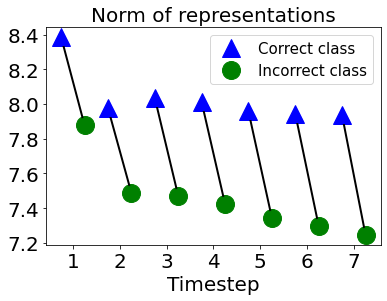

In [16]:
plt.figure(figsize=(6,4))
for t in range(1,timesteps_analyse):
    plt.plot(2*t,norm_stability[t,0],'^', color='blue',markersize=18)
    plt.plot(2*t+1,norm_stability[t,1],'o', color='green',markersize=18)
    plt.plot(range(2*(t),2*t+2),norm_stability[t,:],'k-',linewidth=2)
    plt.plot(2*t,norm_stability[t,0],'^', color='blue',markersize=15)
    plt.plot(2*t+1,norm_stability[t,1],'o', color='green',markersize=15)
plt.legend(['Correct class','Incorrect class'],fontsize=15)
plt.yticks(fontsize=20);
plt.xticks(np.arange(1,timesteps_analyse)*2+0.5,labels=range(1,timesteps_analyse),fontsize=20);
plt.xlabel('Timestep',fontsize=20)
plt.title('Norm of representations',fontsize=20);

print('The norms of representations that will move out of readout zones are lower.')

to_avg_t = np.invert(np.isnan(np.mean(norm_stability[:timesteps_analyse,:],axis=1)))
np.mean(norm_stability[np.arange(timesteps_analyse)[to_avg_t],:],axis=0)

### Are the stable now repr. closer to current readout vector?

In [17]:
cos_currclass_stability = np.zeros([timesteps,2])*np.nan # stable-now, stable-later

for t in range(timesteps):
    
    for idx in range(len(t_stable_correct)):
        if t_stable_correct[idx] < t+1:
            if np.isnan(cos_currclass_stability[t,0]):
                cos_currclass_stability[t,0] = 0.
            cos_currclass_stability[t,0] += cos_sim(avgpool_all[t,stable_correct_ids[idx],:],
                                                    rdout_w[:,np.argmax(outputs_all[t,stable_correct_ids[idx],:])])
        if t_stable_correct[idx] > t:
            if np.isnan(cos_currclass_stability[t,1]):
                cos_currclass_stability[t,1] = 0.
            cos_currclass_stability[t,1] += cos_sim(avgpool_all[t,stable_correct_ids[idx],:],
                                                    rdout_w[:,np.argmax(outputs_all[t,stable_correct_ids[idx],:])])  
            
    if not np.isnan(cos_currclass_stability[t,0]):
        cos_currclass_stability[t,0] = cos_currclass_stability[t,0]/np.sum(t_stable_correct < t+1)
    if not np.isnan(cos_currclass_stability[t,1]):
        cos_currclass_stability[t,1] = cos_currclass_stability[t,1]/np.sum(t_stable_correct > t)
        

The cosines with current readout vector of representations that will move out of readout zones are lower.


array([0.20195132, 0.1209265 ])

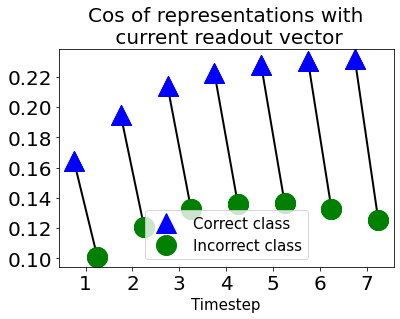

In [18]:
plt.figure(figsize=(6,4))
for t in range(1,timesteps_analyse):
    plt.plot(2*t,cos_currclass_stability[t,0],'^', color='blue',markersize=20)
    plt.plot(2*t+1,cos_currclass_stability[t,1],'o', color='green',markersize=20)
    plt.plot(range(2*(t),2*t+2),cos_currclass_stability[t,:],'k-',linewidth=2)
    plt.plot(2*t,cos_currclass_stability[t,0],'^', color='blue',markersize=20)
    plt.plot(2*t+1,cos_currclass_stability[t,1],'o', color='green',markersize=20)
plt.legend(['Correct class','Incorrect class'],fontsize=15)
plt.yticks(fontsize=20);
plt.xticks(np.arange(1,timesteps_analyse)*2+0.5,labels=range(1,timesteps_analyse),fontsize=20);
plt.xlabel('Timestep',fontsize=15)
plt.title('Cos of representations with\n current readout vector',fontsize=20);

print('The cosines with current readout vector of representations that will move out of readout zones are lower.')

to_avg_t = np.invert(np.isnan(np.mean(cos_currclass_stability[:timesteps_analyse,:],axis=1)))
np.mean(cos_currclass_stability[np.arange(timesteps_analyse)[to_avg_t],:],axis=0)

### Are the stable-after repr. close to their final class?

In [19]:
cos_classes_unstable = np.zeros([timesteps,2])*np.nan # final-class, other-classes-currently

for t in range(timesteps):
    
    idx_h = stable_correct_ids[t_stable_correct > t]
    if len(idx_h) > 0:
        cos_classes_unstable[t,0:2] = 0.
        count_other = 0
        
        for idx in idx_h:

            cos_classes_unstable[t,0] += cos_sim(avgpool_all[t,idx,:], rdout_w[:,int(outputs_all_labels[idx])])
            
            idx_h_c = []
            for idx2 in idx_h:
                if np.argmax(outputs_all[t,idx,:]) == np.argmax(outputs_all[t,idx2,:]):
                    if int(outputs_all_labels[idx]) != int(outputs_all_labels[idx2]):
                        idx_h_c.append(idx2)
            if len(idx_h_c) > 0:
                if np.isnan(cos_classes_unstable[t,1]):
                    cos_classes_unstable[t,1] = 0.
                count_other += len(idx_h_c)
                for idx2 in idx_h_c:
                    cos_classes_unstable[t,1] += cos_sim(avgpool_all[t,idx,:],
                                                         rdout_w[:,int(outputs_all_labels[idx2])])
            
        cos_classes_unstable[t,0] = cos_classes_unstable[t,0]/len(idx_h)
        if not np.isnan(cos_classes_unstable[t,1]):
            cos_classes_unstable[t,1] = cos_classes_unstable[t,1]/count_other
                      

Cos of stable-after representations is higher with corresponding final class than the final classes of other stable-after representations.


array([ 0.09998333, -0.02352951])

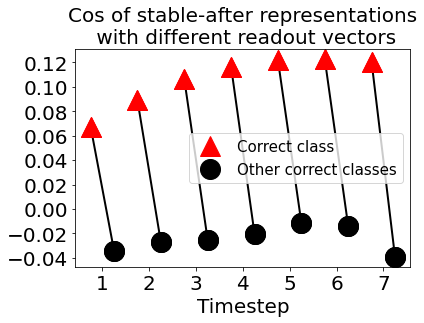

In [20]:
plt.figure(figsize=(6,4))
for t in range(1,timesteps_analyse):
    plt.plot(2*t,cos_classes_unstable[t,0],'^', color='red',markersize=20)
    plt.plot(2*t+1,cos_classes_unstable[t,1],'o', color='black',markersize=20)
    plt.plot(range(2*(t),2*t+2),cos_classes_unstable[t,:],'k-',linewidth=2)
    plt.plot(2*t,cos_classes_unstable[t,0],'^', color='red',markersize=20)
    plt.plot(2*t+1,cos_classes_unstable[t,1],'o', color='black',markersize=20)
plt.legend(['Correct class','Other correct classes'],fontsize=15)
plt.yticks(fontsize=20);
plt.xticks(np.arange(1,timesteps_analyse)*2+0.5,labels=range(1,timesteps_analyse),fontsize=20);
plt.xlabel('Timestep',fontsize=20)
plt.title('Cos of stable-after representations\n with different readout vectors',fontsize=20);

print('Cos of stable-after representations is higher with corresponding final class than the final classes\
 of other stable-after representations.')

to_avg_t = np.invert(np.isnan(np.mean(cos_classes_unstable[:timesteps_analyse,:],axis=1)))
np.mean(cos_classes_unstable[np.arange(timesteps_analyse)[to_avg_t],:],axis=0)

### Comparison of metrics across network types

In [21]:
# Run the above script for the various RNN configurations - get the summary statistics and insert them here to visualise.
meas_diffs = np.zeros([2,2,2,3]) # diffs, L vs T, add vs mult, norm/cos/cos_other

meas_diffs[:,0,0,0] = np.array([8.03511149, 7.44929842]) # L - add
meas_diffs[:,1,0,0] = np.array([22.99320437, 22.43494606]) # T - add
meas_diffs[:,0,1,0] = np.array([24.14761542, 23.58096064]) # L - mult
meas_diffs[:,1,1,0] = np.array([22.43415347, 21.82737927]) # T - mult

meas_diffs[:,0,0,1] = np.array([0.20195132, 0.1209265 ])
meas_diffs[:,1,0,1] = np.array([0.06167901, 0.01399343])
meas_diffs[:,0,1,1] = np.array([0.13583924, 0.07096022])
meas_diffs[:,1,1,1] = np.array([0.08779555, 0.03271532])

meas_diffs[:,0,0,2] = np.array([ 0.09998333, -0.02352951])
meas_diffs[:,1,0,2] = np.array([ 0.00296173, -0.0740004 ])
meas_diffs[:,0,1,2] = np.array([ 0.05162896, -0.03233384])
meas_diffs[:,1,1,2] = np.array([ 0.01683858, -0.06554172])

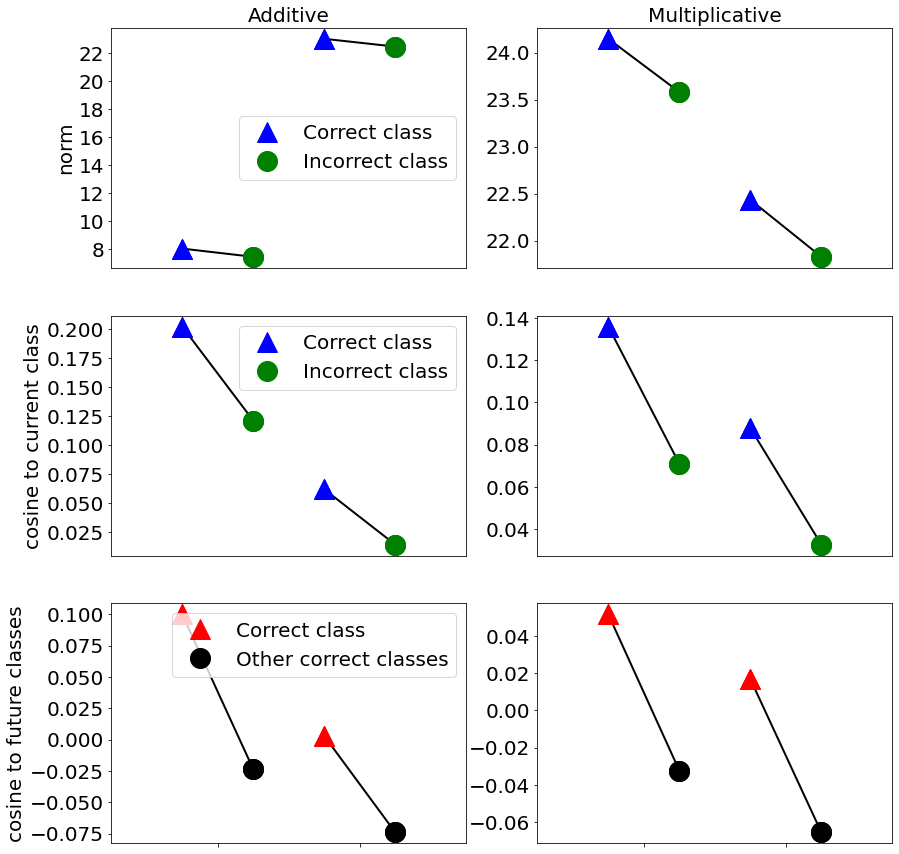

In [22]:
ylabels_h = [r'norm',r'cosine to current class',r'cosine to future classes']
titles_h = ['Additive','Multiplicative']

plt.figure(figsize=(14,15))
for intr in range(2):
    for meas in range(3):
        plt.subplot(3,2,intr+meas*2+1)
        for i in range(2):
            if meas < 2:
                plt.plot(0+i*2,meas_diffs[0,i,intr,meas],'b^',markersize=20)
                plt.plot(1+i*2,meas_diffs[1,i,intr,meas],'o', color='green',markersize=20)
                plt.plot(np.arange(2)+i*2,meas_diffs[:,i,intr,meas],'k-',linewidth=2)
                plt.plot(0+i*2,meas_diffs[0,i,intr,meas],'b^',markersize=20)
                plt.plot(1+i*2,meas_diffs[1,i,intr,meas],'o', color='green',markersize=20)
            else:
                plt.plot(0+i*2,meas_diffs[0,i,intr,meas],'r^',markersize=20)
                plt.plot(1+i*2,meas_diffs[1,i,intr,meas],'o', color='k',markersize=20)
                plt.plot(np.arange(2)+i*2,meas_diffs[:,i,intr,meas],'k-',linewidth=2)
                plt.plot(0+i*2,meas_diffs[0,i,intr,meas],'r^',markersize=20)
                plt.plot(1+i*2,meas_diffs[1,i,intr,meas],'o', color='k',markersize=20)
            if meas == 2:
                plt.xticks([0.5,2.5],labels=['',''],fontsize=20)
            else:
                plt.xticks([])
            plt.xlim([-1,4])
            plt.yticks(fontsize=20)
            if intr == 0:
                plt.ylabel(ylabels_h[meas],fontsize=20)
                if meas == 0:
                    plt.legend(['Correct class','Incorrect class'],fontsize=20)
                if meas == 1:
                    plt.legend(['Correct class','Incorrect class'],fontsize=20)
                if meas == 2:
                    plt.legend(['Correct class','Other correct classes'],fontsize=20)
            if meas == 0:
                plt.title(titles_h[intr],fontsize=20)

## Supplementary analysis

### Shape of the readout zones in 2D

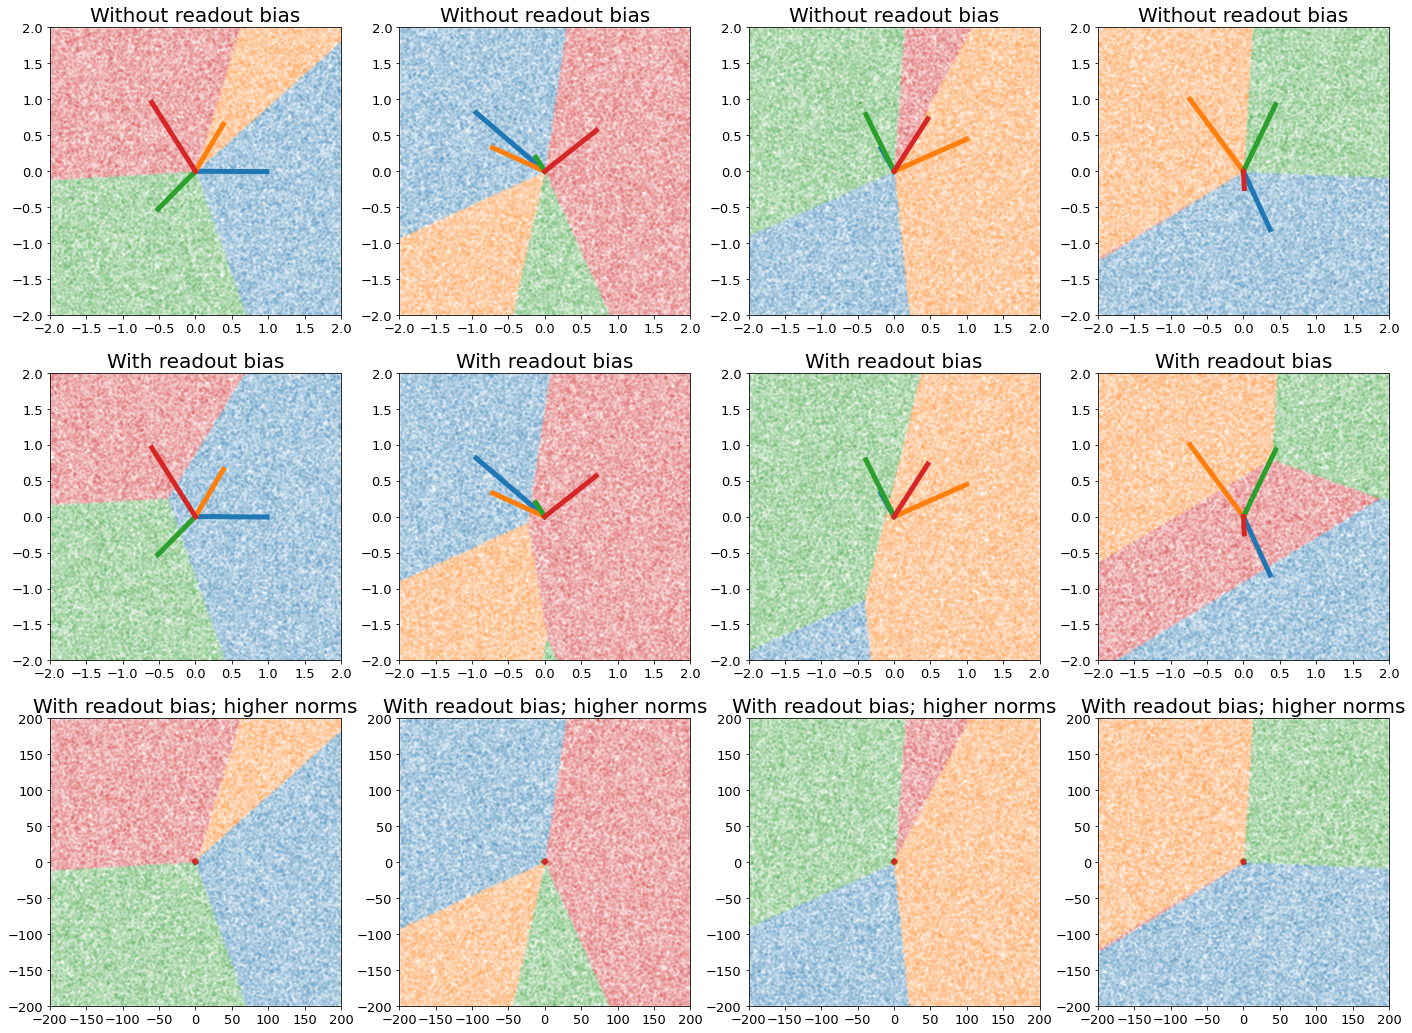

In [23]:
d_o = 4
d_r = 2
n = 100000
radius = 2
radius_multiplier = 100

plt.figure(figsize=(24,18))
for i in range(4):
    
    M = np.random.uniform(low=-(6**0.5)/(d_r+d_o)**0.5,high=(6**0.5)/(d_r+d_o)**0.5,size=[d_o,d_r])

    r = np.random.uniform(low=-radius,high=radius,size=[n,d_r])

    o_prime = r@M.T
    o_decision = np.argsort(o_prime,1)[:,d_o-1]
    
    plt.subplot(3,4,i+1)
    for dec in range(d_o):
        plt.scatter(r[o_decision==dec,0],r[o_decision==dec,1],marker='.',linewidths=0.01, alpha=0.05)
        plt.plot([0,M[dec,0]],[0,M[dec,1]],linewidth=5)
    plt.xlim([-radius,radius])
    plt.ylim([-radius,radius])
    plt.yticks(fontsize=13);
    plt.xticks(fontsize=13);
    plt.title('Without readout bias',fontsize=20)

    b = np.random.uniform(low=-(6**0.5)/(1+d_o)**0.5,high=(6**0.5)/(1+d_o)**0.5,size=[d_o,1])

    r = np.random.uniform(low=-radius,high=radius,size=[n,d_r])

    o_prime = r@M.T+b.T
    o_decision = np.argsort(o_prime,1)[:,d_o-1]
    
    plt.subplot(3,4,i+5)
    for dec in range(d_o):
        plt.scatter(r[o_decision==dec,0],r[o_decision==dec,1],marker='.',linewidths=0.01, alpha=0.05)
        plt.plot([0,M[dec,0]],[0,M[dec,1]],linewidth=5)
    plt.xlim([-radius,radius])
    plt.ylim([-radius,radius])
    plt.yticks(fontsize=13);
    plt.xticks(fontsize=13);
    plt.title('With readout bias',fontsize=20) 
    
    r = np.random.uniform(low=-radius*radius_multiplier,high=radius*radius_multiplier,size=[n,d_r])
    
    o_prime = r@M.T+b.T
    o_decision = np.argsort(o_prime,1)[:,d_o-1]
    
    plt.subplot(3,4,i+9)
    for dec in range(d_o):
        plt.scatter(r[o_decision==dec,0],r[o_decision==dec,1],marker='.',linewidths=0.01, alpha=0.05)
        plt.plot([0,M[dec,0]],[0,M[dec,1]],linewidth=5)
    plt.xlim([-radius*radius_multiplier,radius*radius_multiplier])
    plt.ylim([-radius*radius_multiplier,radius*radius_multiplier])
    plt.yticks(fontsize=13);
    plt.xticks(fontsize=13);
    plt.title('With readout bias; higher norms',fontsize=20)

### Implications for our results

In [24]:
# Checking if the RNN's readout vectors lie within the corresponding readout zones

o_prime = rdout_w.T @ rdout_w;
o_decision = np.argsort(o_prime,0)[-1,:];
print('Prop. of readout vectors in their corresponding readout zones:',np.mean(o_decision == np.arange(100))*100,'%')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Prop. of readout vectors in their corresponding readout zones: 100.0 %


In [25]:
# Checking the reliance of the above result on the dimensionality of the repr. space
import random

d_o = 100 # 100 readouts
d_r = np.arange(50)+1 # repr. D

n_reps = 100
acc_rvecs = np.zeros([len(d_r),n_reps,2])

for dim in d_r:
    for rep in range(n_reps):
        M = np.random.uniform(low=-(6**0.5)/(dim+d_o)**0.5,high=(6**0.5)/(dim+d_o)**0.5,size=[d_o,dim])
        o_prime = M @ M.T
        o_decision = np.argsort(o_prime,0)[-1,:]
        acc_rvecs[dim-1,rep,0] = np.mean(o_decision == np.arange(d_o))*100
        
        dim_choose = random.sample(range(512), dim)
        M = rdout_w[dim_choose,:].T
        o_prime = M @ M.T
        o_decision = np.argsort(o_prime,0)[-1,:]
        acc_rvecs[dim-1,rep,1] = np.mean(o_decision == np.arange(d_o))*100

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


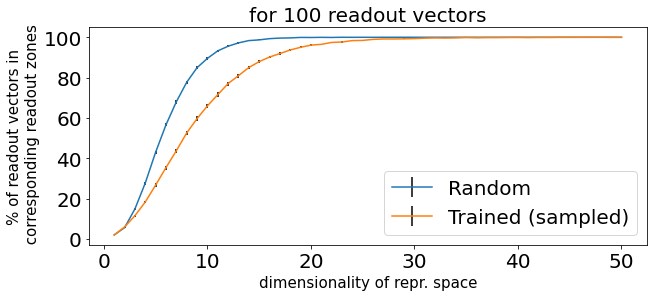

In [26]:
plt.figure(figsize=(10,4))

for i in range(2):
    plt.errorbar(d_r,np.mean(acc_rvecs[:,:,i],1),1.96*np.std(acc_rvecs[:,:,i],1)/n_reps**0.5, ecolor='k')
plt.yticks(fontsize=20);
plt.xticks(fontsize=20);
plt.legend(['Random','Trained (sampled)'],fontsize=20)
plt.ylabel('% of readout vectors in\n corresponding readout zones',fontsize=15);
plt.xlabel('dimensionality of repr. space',fontsize=15);
plt.title('for 100 readout vectors',fontsize=20);
plt.savefig('rvec_alignment.png',dpi=300, bbox_inches='tight')

### The representational arrangement in the B-only network and a ResNet18 trained on Miniecoset

In [27]:
net_name_b = f'b64_l_0_t_0_ltinteract_None_T_1_ltposition_None_num_{net_num}'
actvs_save_name_b = f'saved_actvs/{net_name_b}/{net_name_b}.npz'
actvs_save_name_b_init = f'saved_actvs/{net_name_b}/{net_name_b}_epoch_-1.npz'

data = np.load(actvs_save_name_b)
outputs_all_b = np.exp(data['outputs_all'])
avgpool_all_b = data['representations_all']
rdout_w_b = data['readout_weight'].T
rdout_b_b = data['readout_bias']

data = np.load(actvs_save_name_b_init)
outputs_all_b_init = np.exp(data['outputs_all'])
avgpool_all_b_init = data['representations_all']
rdout_w_b_init = data['readout_weight'].T
rdout_b_b_init = data['readout_bias']

data = np.load('r18_feats.npz')
r18_feats = data['r18_feats']
r18_rdout_w = data['rdout_w']
r18_rdout_b = data['rdout_b']

In [28]:
mean_norm_b = np.array([np.mean(norm(avgpool_all_b[0,stable_correct_ids[t_stable_correct==t],:],axis=1)) 
                        for t in range(timesteps_analyse)])
sem_norm_b = np.array([np.std(norm(avgpool_all_b[0,stable_correct_ids[t_stable_correct==t],:],axis=1))/np.sum(t_stable_correct==t)**0.5 
                       for t in range(timesteps_analyse)])
mean_norm_b_init = np.array([np.mean(norm(avgpool_all_b_init[0,stable_correct_ids[t_stable_correct==t],:],axis=1)) 
                             for t in range(timesteps_analyse)])
sem_norm_b_init = np.array([np.std(norm(avgpool_all_b_init[0,stable_correct_ids[t_stable_correct==t],:],axis=1))/np.sum(t_stable_correct==t)**0.5
                            for t in range(timesteps_analyse)])
mean_norm_r18 = np.array([np.mean(norm(r18_feats[stable_correct_ids[t_stable_correct==t],:],axis=1))
             for t in range(timesteps_analyse)])
sem_norm_r18 = np.array([np.std(norm(r18_feats[stable_correct_ids[t_stable_correct==t],:],axis=1))/np.sum(t_stable_correct==t)**0.5 
                         for t in range(timesteps_analyse)])

Correlation stats for B-net (init): SignificanceResult(statistic=0.0026733960402155086, pvalue=0.702748100421126)
Correlation stats for B-net: SignificanceResult(statistic=-0.10365566825627462, pvalue=1.5474075352524498e-49)
Correlation stats for ResNet18: SignificanceResult(statistic=-0.11176176844456463, pvalue=2.697375131501645e-57)
The norm arrangement in RNNs is also found in feedforward nets.


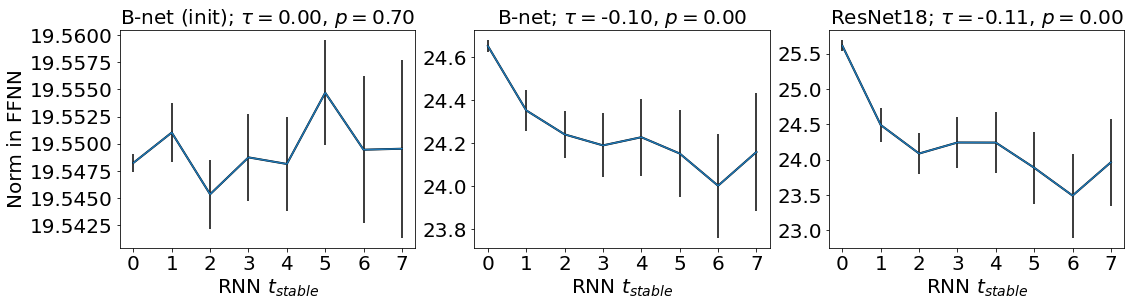

In [29]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.errorbar(np.arange(timesteps_analyse),mean_norm_b_init,1.96*sem_norm_b_init, ecolor='k')
plt.plot(np.arange(timesteps_analyse),mean_norm_b_init,'k-',linewidth=2)
plt.yticks(fontsize=20);
plt.xticks(np.arange(timesteps_analyse),labels=range(timesteps_analyse),fontsize=20);
t_corr = scipy.stats.kendalltau(norm(avgpool_all_b_init[0,stable_correct_ids,:],axis=1),t_stable_correct)
plt.title(fr'B-net (init); $\tau=${t_corr.statistic:.2f}, $p=${t_corr.pvalue:.2f}',fontsize=20);
print('Correlation stats for B-net (init):',t_corr)
plt.ylabel('Norm in FFNN',fontsize=20);
plt.xlabel('RNN $t_{stable}$',fontsize=20);
plt.subplot(1,3,2)
plt.errorbar(np.arange(timesteps_analyse),mean_norm_b,1.96*sem_norm_b, ecolor='k')
plt.plot(np.arange(timesteps_analyse),mean_norm_b,'k-',linewidth=2)
plt.yticks(fontsize=20);
plt.xticks(np.arange(timesteps_analyse),labels=range(timesteps_analyse),fontsize=20);
t_corr = scipy.stats.kendalltau(norm(avgpool_all_b[0,stable_correct_ids,:],axis=1),t_stable_correct)
plt.title(fr'B-net; $\tau=${t_corr.statistic:.2f}, $p=${t_corr.pvalue:.2f}',fontsize=20);
print('Correlation stats for B-net:',t_corr)
plt.xlabel('RNN $t_{stable}$',fontsize=20);
plt.subplot(1,3,3)
plt.errorbar(np.arange(timesteps_analyse),mean_norm_r18,1.96*sem_norm_r18, ecolor='k')
plt.plot(np.arange(timesteps_analyse),mean_norm_r18,'k-',linewidth=2)
plt.yticks(fontsize=20);
plt.xticks(np.arange(timesteps_analyse),labels=range(timesteps_analyse),fontsize=20);
t_corr = scipy.stats.kendalltau(norm(r18_feats[stable_correct_ids,:],axis=1),t_stable_correct)
plt.title(fr'ResNet18; $\tau=${t_corr.statistic:.2f}, $p=${t_corr.pvalue:.2f}',fontsize=20);
print('Correlation stats for ResNet18:',t_corr)
plt.xlabel('RNN $t_{stable}$',fontsize=20);

print('The norm arrangement in RNNs is also found in feedforward nets.')